In [1]:
from collections import defaultdict
from run import ScriptArguments, get_pz_list
from datasets import fingerprint
from transformers import HfArgumentParser, set_seed
import torch
from typing import cast
from datasets.utils._dill import dumps
import os

def pull_data(arg_cls, api, seed_list, max_xw_list, model_name_list, num_test_examples_list, pz_end, pz_start, pz_dist, pz_count):
    num_test_examples_list = sorted(num_test_examples_list, reverse=True)
    
    configs = {}
    results = defaultdict(list)
    for seed in seed_list:
        for max_xw in max_xw_list:
            for model_name in model_name_list:
                # find the result with the biggest number of test examples
                for num_test_examples in num_test_examples_list:
                    config = arg_cls(
                        debug=False,
                        api=api,
                        seed=seed,
                        model_name=model_name,
                        max_w=max_xw,
                        max_x=max_xw,
                        pz_end=pz_end,
                        pz_start=pz_start,
                        pz_dist=pz_dist,
                        pz_count=pz_count,
                        num_test_examples=num_test_examples,
                        device='cuda:1'
                    )
                    set_seed(seed)
                    fp_old = fingerprint.Hasher().hash(tuple(sorted(config.__dict__.items())))
                    fp_new = repr(config)
                    # print(fp)
                    for fp in [fp_old, fp_new]:
                        folder = f'{config.out_dir}/cache/{fp}/'
                        if os.path.exists(folder):
                            break
                    else:
                        continue
                    break

                all_answers = torch.load(f'{config.out_dir}/cache/{fp}/answers.pt')
                all_targets = torch.load(f'{config.out_dir}/cache/{fp}/targets.pt')
                mse = (all_answers - all_targets).float() / (config.max_w * config.max_x) # (num_test_examples, len(pz_list))
                mse_pad = torch.cat([mse, torch.nan * torch.ones(num_test_examples_list[0] - mse.shape[0], mse.shape[1])])
                results[(max_xw, model_name)].append(mse_pad)
                configs[(max_xw, model_name)] = config

    results = {k: torch.stack(results[k]) for k in results}
    return results, configs


In [3]:
# list(results.values())[0].shape # (num_seeds, num_test_examples, len(pz_list))

In [7]:
from matplotlib import pyplot as plt
from random import choices

from numpy import sqrt

def plot_2x2_avg(results, configs, x_list, w_list, logx=False, logy=True, vline=None):
    def remove_outliers(data, *others):
        return data[data <= 1], *[o[data <= 1] for o in others]

    fig = plt.figure(figsize=(6 * len(w_list), 4.5 * len(x_list)))
    axs = fig.subplots(len(x_list), len(w_list))
    for col, avg_over_w in enumerate(w_list):
        for row, avg_over_x in enumerate(x_list):
            for k in results:
                res_mask = (~results[k].isnan()).sum(dim=-1)
                # print(res_mask)
                avail_w = torch.count_nonzero(res_mask, dim=0) >= avg_over_w
                avail_x = torch.count_nonzero(res_mask, dim=1) >= avg_over_x
                avail = torch.outer(avail_x, avail_w)
                # print(avail)
                i, j = torch.nonzero(avail, as_tuple=True)
                if len(i) < avg_over_w or len(j) < avg_over_x:
                    print(f'Not enough data for {k[1]} {k[0]}')
                    continue
                i, j = choices(i, k=avg_over_w), choices(j, k=avg_over_x)
                # print(i, j)
                dat = results[k][i, :, :][:, j, :]
                # dat = torch.log(dat)
                # print(dat.shape)
                # dat_mean = dat.flatten(0, 1).abs().mean(dim=0)
                dat_mse = dat.flatten(0, 1).pow(2).mean(dim=0)
                # if dat.shape[0] == 1 and dat.shape[1] == 1: # cannot compute variance
                #     dat_var = torch.zeros_like(dat_mean)
                # else:
                #     dat_var = dat.flatten(0, 1).std(dim=0)
                # print(dat.shape)
                labels = torch.tensor(get_pz_list(configs[k]))
                # dat_mean, dat_var, labels = remove_outliers(dat_mean, dat_var, labels)
                # axs[row][col].plot(labels, dat_mean, label=f'{k[1]} {k[0]}')
                # axs[row][col].plot(labels, dat_var, color='gray', linestyle='--')
                # axs[row][col].fill_between(labels, dat_mean - dat_var, dat_mean + dat_var, alpha=0.2)
                dat_mse, labels = remove_outliers(dat_mse, labels)
                axs[row][col].plot(labels, dat_mse, label=f'{k[1]} {k[0]}')
            if vline: axs[row][col].vlines(vline, 0, 1, color='red', linestyle='--')
            axs[row][col].set_xlabel('Prompt size')
            axs[row][col].set_ylabel('RMSE')
            if logy: axs[row][col].semilogy()
            if logx: axs[row][col].semilogx()
            axs[row][col].legend()
            axs[row][col].set_title(f'Prompt size vs RMSE, average over {avg_over_w} weights, {avg_over_x} examples')

    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
Not enough data for meta-llama/Meta-Llama-3-8B 1000


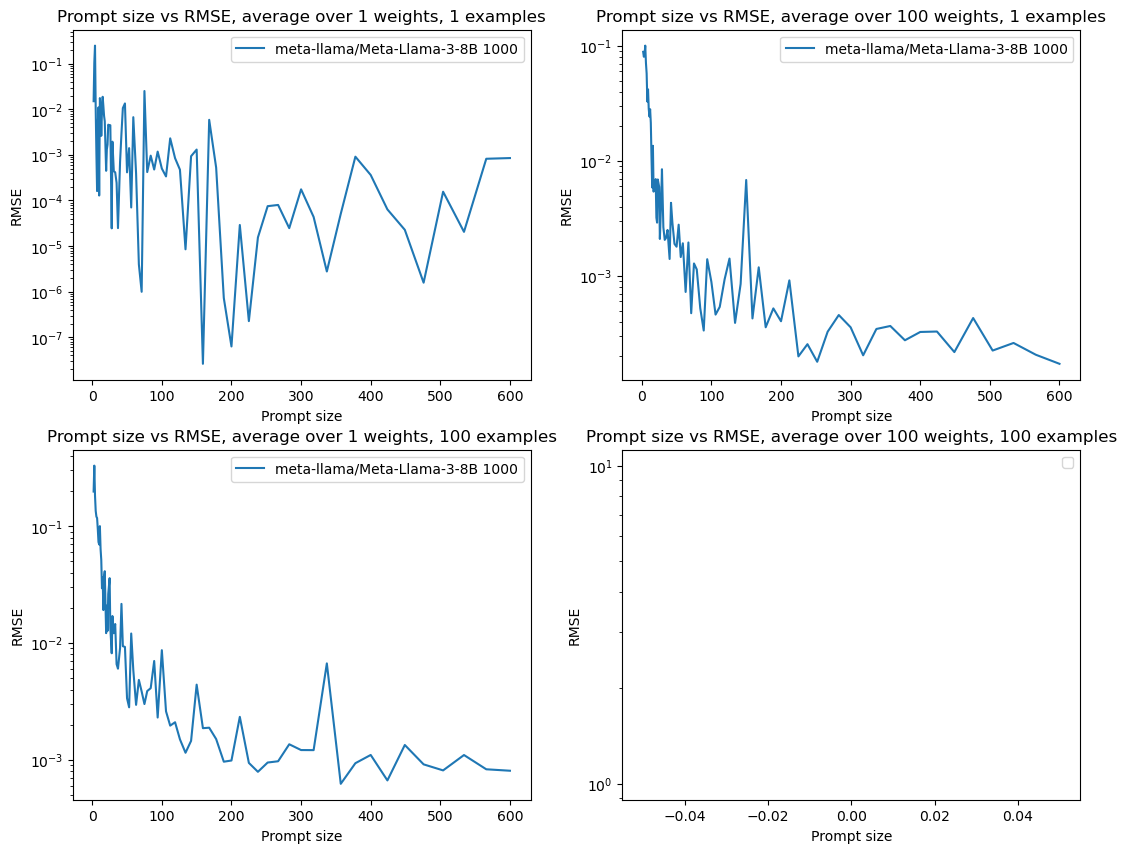

In [5]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class ScriptArguments:
    wandb_project: str = 'multiple-acsent'
    debug: bool = False
    out_dir: str = 'results'
    
    api: str | None = None
    model_name: str = "meta-llama/Meta-Llama-3-8B"
    batch_size: int | None = None
    seed: int = 42
    device: str = 'cuda:0'

    max_new_tokens: int = 10
    pz_end: int = 800
    pz_start: int = 20
    pz_count: int = 5
    pz_dist: str = 'uniform'
    num_test_examples: int = 100

    input_dim: int = 2
    max_w: int = 1000
    max_x: int = 1000
results, configs = pull_data(ScriptArguments, api='togetherai', seed_list=range(100), max_xw_list=[1000], model_name_list=['meta-llama/Meta-Llama-3-8B'], num_test_examples_list=[100, 1], pz_end=600, pz_start=2, pz_dist='log', pz_count=100)
plot_2x2_avg(results, configs, x_list=[1, 100], w_list=[1, 100])


In [6]:
    # for model_name in ['meta-llama/Meta-Llama-3-8B', 'meta-llama/Meta-Llama-3-70B']:
    #     pz_end = 600
    #     pz_count = 50
    #     pz_dist = 'log'
    #     num_test_examples = 10
    # for model_name in ['Qwen/Qwen1.5-32B']:
    #     pz_end = 1000
        # pz_count = 50
    #     pz_dist = 'log'
        # num_test_examples = 10

pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates


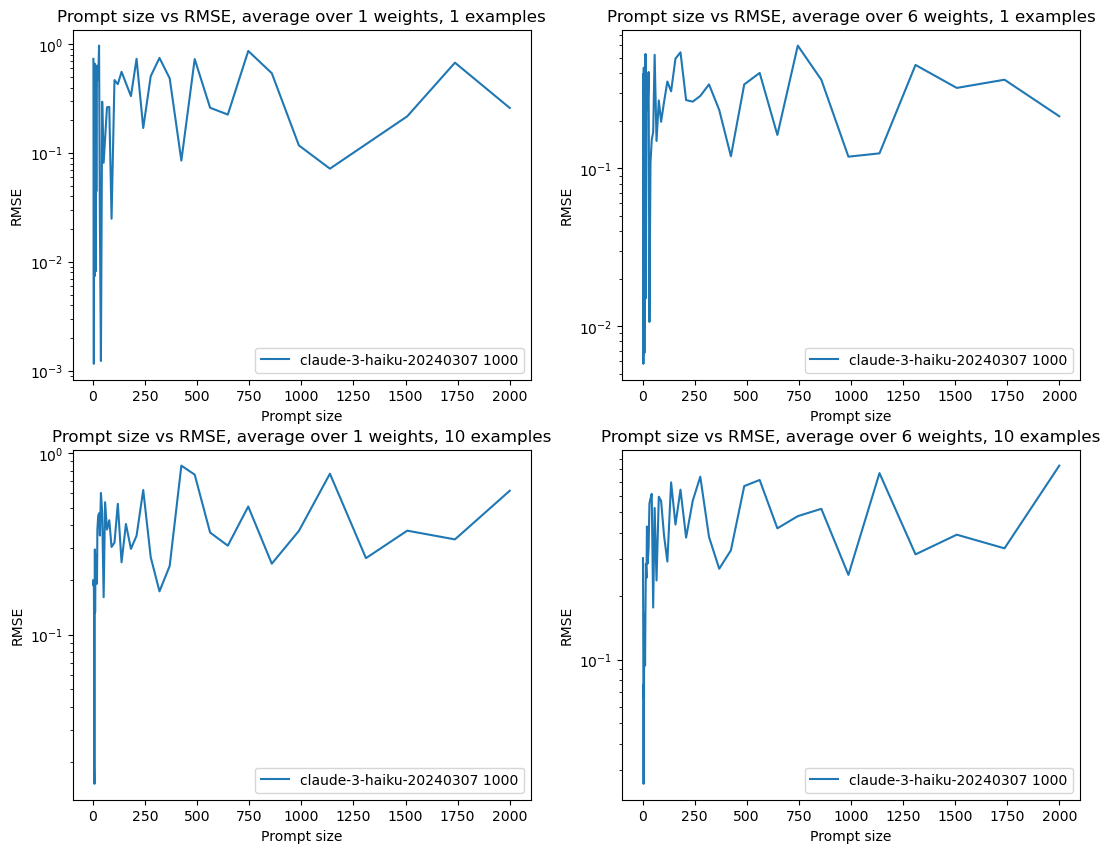

In [7]:
@dataclass
class ScriptArguments:
    wandb_project: str = 'multiple-acsent'
    debug: bool = False
    out_dir: str = 'results'
    
    api: str | None = None
    model_name: str = "meta-llama/Meta-Llama-3-8B"
    batch_size: int | None = None
    seed: int = 42
    device: str = 'cuda:0'

    max_new_tokens: int = 10
    pz_end: int = 800
    pz_start: int = 20
    pz_count: int = 5
    pz_dist: str = 'uniform'
    num_test_examples: int = 100
    test_x_range: Tuple[int, int] = (0, 1000)

    input_dim: int = 2
    max_w: int = 1000
    max_x: int = 1000
results, configs = pull_data(ScriptArguments, api='anthropic', seed_list=[0,1,2,3,4,5], max_xw_list=[1000], model_name_list=['claude-3-haiku-20240307'], num_test_examples_list=[10], pz_end=2000, pz_start=2, pz_dist='log', pz_count=50)
plot_2x2_avg(results, configs, x_list=[1, 10], w_list=[1, 6])

# Print some answers from haiku
haiku_all_answers = torch.load(f'results/cache/b8330273ca0b2831/answers.pt')
haiku_pz = get_pz_list(configs[(1000, 'claude-3-haiku-20240307')])

print(list(zip(haiku_pz, haiku_all_answers[0].tolist())))



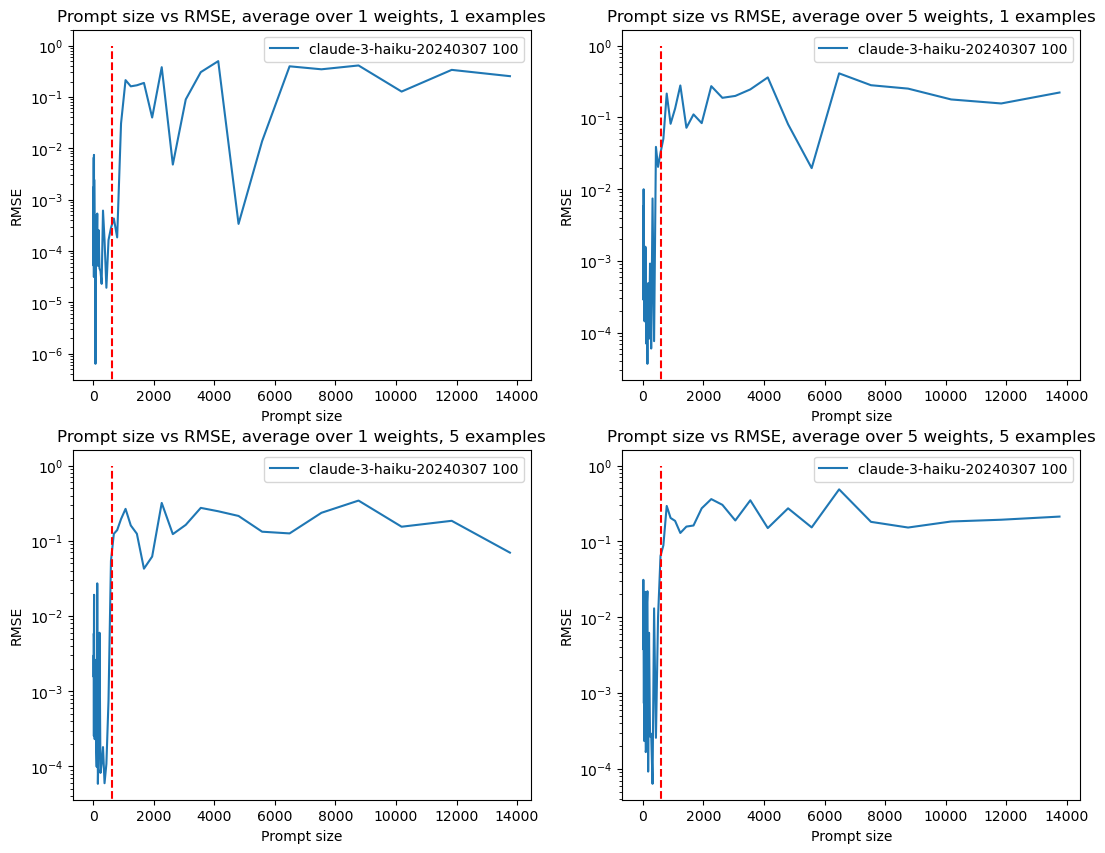

In [8]:
results, configs = pull_data(ScriptArguments, api='anthropic', seed_list=range(0, 5), max_xw_list=[100], model_name_list=['claude-3-haiku-20240307'], num_test_examples_list=[5], pz_end=16000, pz_start=10, pz_dist='log', pz_count=50)
plot_2x2_avg(results, configs, x_list=[1, 5], w_list=[1, 5], logx=False, vline=600)

pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates


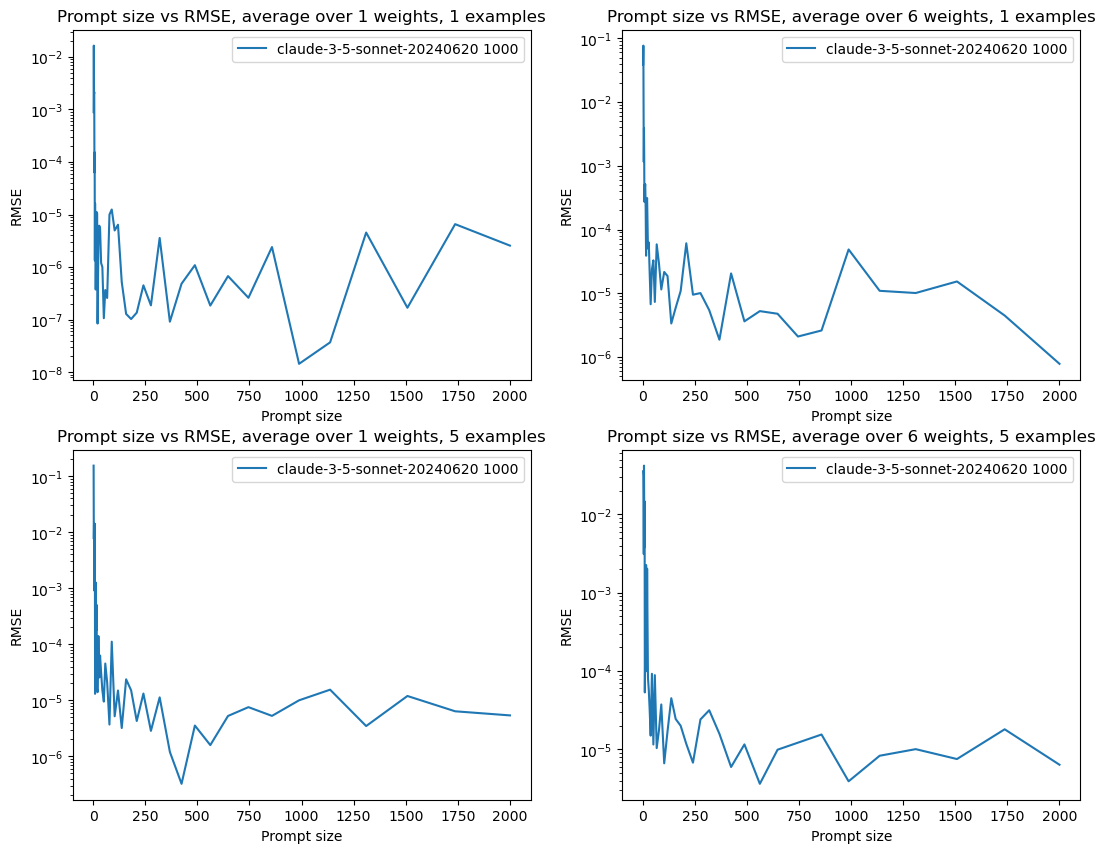

In [ ]:
results, configs = pull_data(ScriptArguments, api='anthropic', seed_list=[0,1,2,3,4,5], max_xw_list=[1000], model_name_list=['claude-3-5-sonnet-20240620'], num_test_examples_list=[5], pz_end=2000, pz_start=2, pz_dist='log', pz_count=50)
plot_2x2_avg(results, configs, x_list=[1, 5], w_list=[1, 6])

pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates
pz_list contains duplicate values, removing duplicates


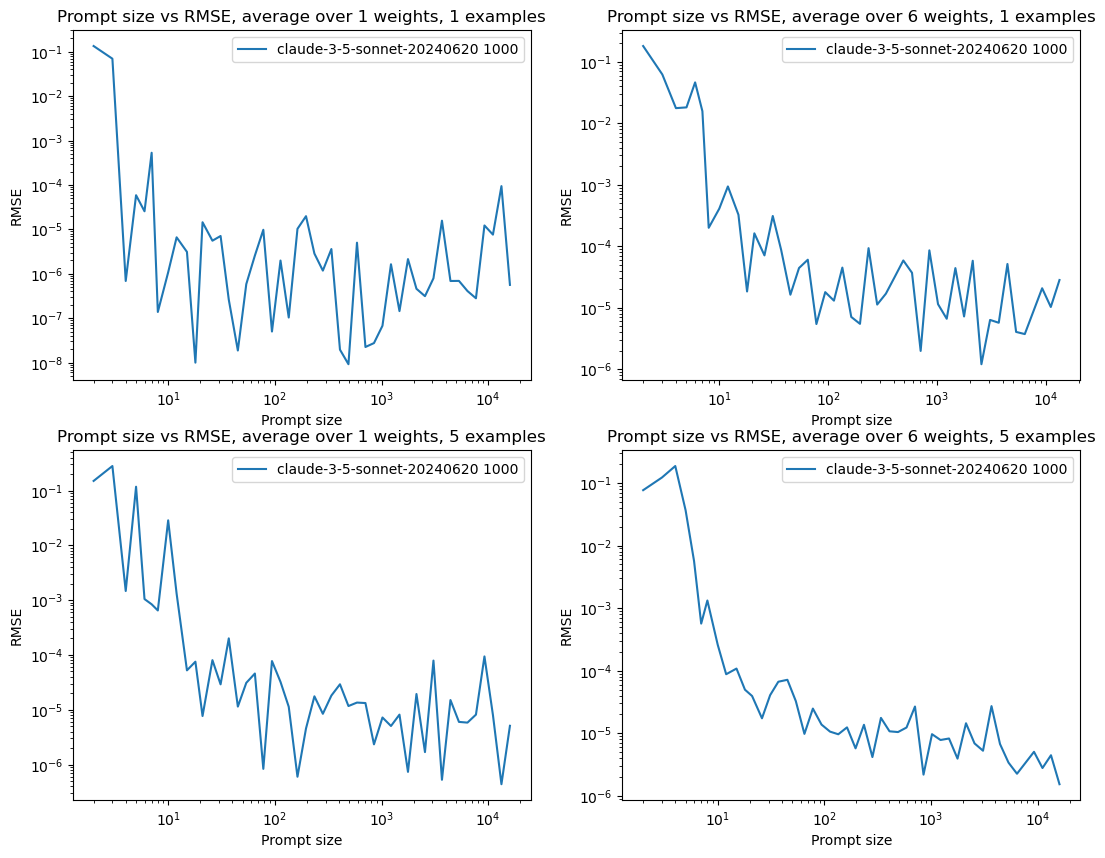

In [ ]:
results, configs = pull_data(ScriptArguments, api='anthropic', seed_list=range(6), max_xw_list=[1000], model_name_list=['claude-3-5-sonnet-20240620'], num_test_examples_list=[5], pz_end=16000, pz_start=2, pz_dist='log', pz_count=50)
plot_2x2_avg(results, configs, x_list=[1, 5], w_list=[1, 6], logx=True)


f69ef858b5d959db
3b613eb1d7bc2a0f
b4c00b24b4bed33e
f3e3716e107e843e
c36e848512b151c9
18cf9e2aca6d79a4


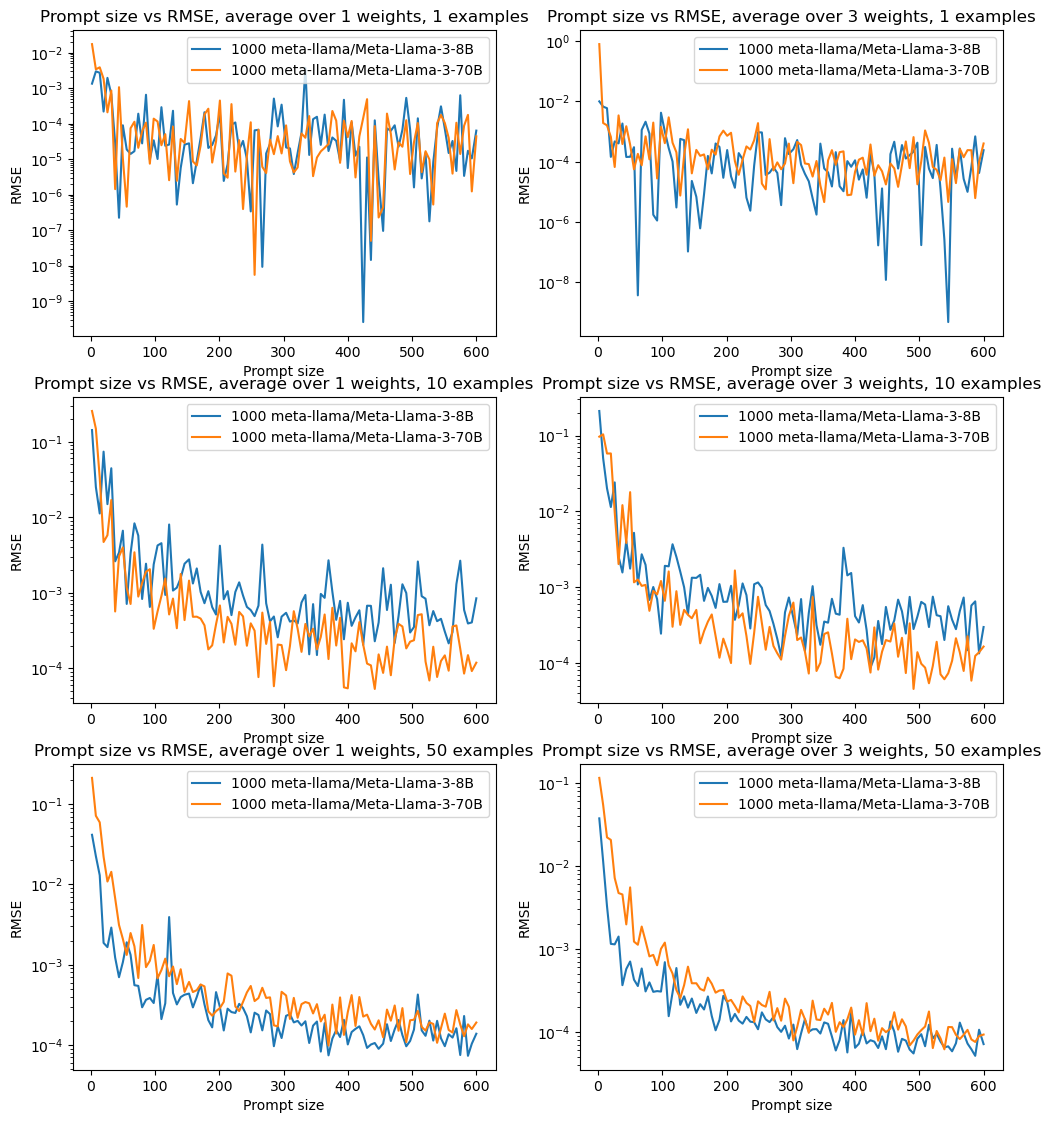

In [19]:
from run import ScriptArguments, get_pz_list
from typing import List
from collections import defaultdict
from datasets import fingerprint
import os
import torch


def pull_data(arg_list: List[ScriptArguments], get_key):
    configs = {}
    results = defaultdict(list)
    for config in arg_list:
        # set_seed(config.seed)
        fp_old = fingerprint.Hasher().hash(tuple(sorted(config.__dict__.items())))
        fp_new = repr(config)
        print(fp_old)
        for fp in [fp_old, fp_new]:
            folder = f'{config.out_dir}/cache/{fp}/'
            if os.path.exists(folder):
                break
        else:
            raise FileNotFoundError(f'No cache found for {config}')

        all_answers = torch.load(f'{config.out_dir}/cache/{fp}/answers.pt')
        all_targets = torch.load(f'{config.out_dir}/cache/{fp}/targets.pt')
        # dataset = torch.load(f'{config.out_dir}/cache/{fp}/dataset.pt')
        mse = (all_answers - all_targets).float() / ((config.w_range[1] - config.w_range[0]) * (config.x_range[1] - config.x_range[0])) # (num_test_examples, len(pz_list))
        mse_pad = torch.cat([mse, torch.nan * torch.ones(num_test_examples - mse.shape[0], mse.shape[1])])
        key = get_key(config)
        results[key].append(mse_pad)
        configs[key] = config

    results = {k: torch.stack(results[k]) for k in results}
    return results, configs

def get_key(config):
    return (config.model_name, config.w_range[1])

api = 'togetherai'
seed_list = range(3)
max_xw = 1000
model_name_list = ['meta-llama/Meta-Llama-3-8B', 'meta-llama/Meta-Llama-3-70B']
num_test_examples = 50
arg_list = []
for seed in seed_list:
    for model_name in model_name_list:
        arg_list.append(
            ScriptArguments(
                debug=False,
                api=api,
                seed=seed,
                model_name=model_name,
                w_range=[0, max_xw],
                x_range=[0, max_xw],
                pz_end=600,
                pz_start=2,
                pz_dist='uniform',
                pz_count=100,
                num_test_examples=num_test_examples,
                device='cuda:1',
                dataset_type='shuffle'
            )
        )

# api = 'baseline'
# model_name = 'KNN'
# for seed in seed_list:
#     arg_list.append(
#         ScriptArguments(
#             debug=False,
#             api=api,
#             seed=seed,
#             model_name=model_name,
#             w_range=[0, max_xw],
#             x_range=[0, max_xw],
#             pz_end=600,
#             pz_start=2,
#             pz_dist='uniform',
#             pz_count=100,
#             num_test_examples=num_test_examples,
#             device='cuda:1',
#             dataset_type='shuffle'
#         )
#     )

results, configs = pull_data(arg_list, get_key)
plot_2x2_avg(results, configs, x_list=[1, 10, 50], w_list=[1, 3], logx=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c09bbe95e2dc882c
Not enough data for 1000 claude-3-5-sonnet-20240620
Not enough data for 1000 claude-3-5-sonnet-20240620


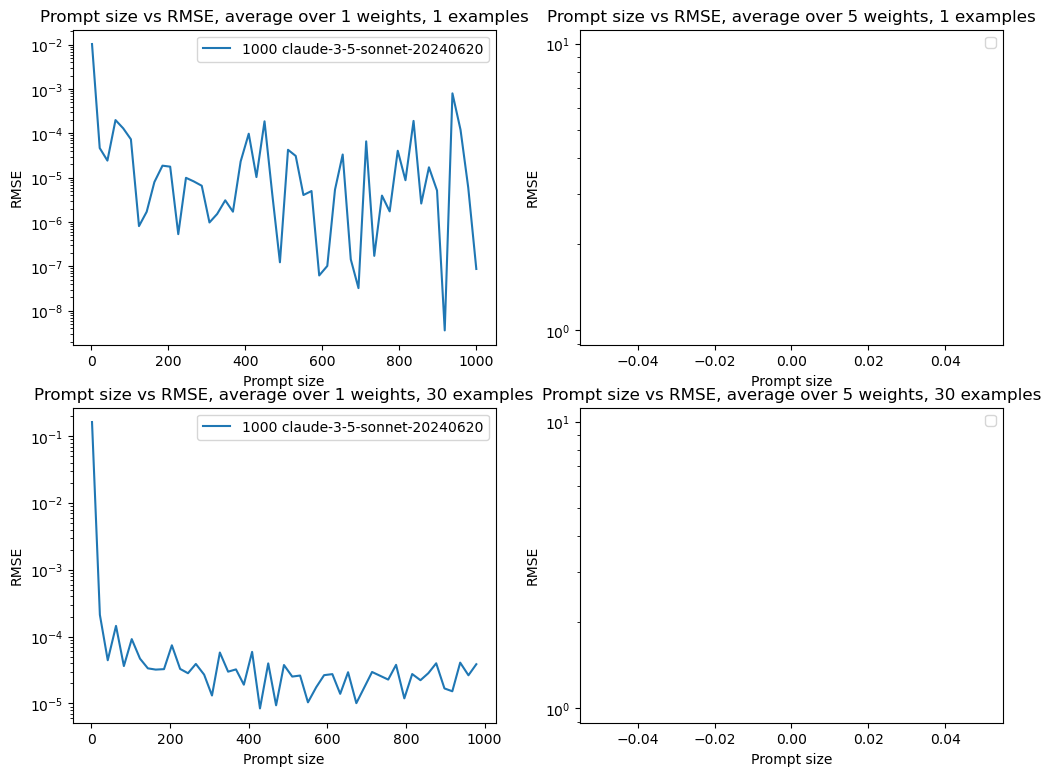

In [22]:
from run import ScriptArguments
from typing import List

api = 'anthropic'
seed_list = range(1)
max_xw = 1000
model_name_list = ['claude-3-5-sonnet-20240620']
num_test_examples = 30
arg_list = []
for seed in seed_list:
    for model_name in model_name_list:
        arg_list.append(
            ScriptArguments(
                debug=False,
                api=api,
                seed=seed,
                model_name=model_name,
                w_range=[0, max_xw],
                x_range=[0, max_xw],
                pz_end=1000,
                pz_start=2,
                pz_dist='uniform',
                pz_count=50,
                num_test_examples=num_test_examples,
                device='cuda:1',
                dataset_type='shuffle'
            )
        )

results, configs = pull_data(arg_list, get_key)
plot_2x2_avg(results, configs, x_list=[1, 30], w_list=[1, 5], logx=False)

In [ ]:
 ScriptArguments(wandb_project='multiple-acsent', debug=False, out_dir='results', seed=0, device='cuda:1', api='anthropic', model_name='claude-3-5-sonnet-20240620', batch_size=None, max_new_tokens=10, pz_end=2000, pz_start=2, pz_count=50, pz_dist='uniform', num_test_examples=30, test_x_range=[0, 1000], input_dim=2, w_range=[0, 1000], x_range=[0, 1000], dataset_type='shuffle')
 ScriptArguments(wandb_project='multiple-acsent', debug=False, out_dir='results', seed=0, device='cuda:1', api='anthropic', model_name='claude-3-5-sonnet-20240620', batch_size=None, max_new_tokens=10, pz_end=1000, pz_start=2, pz_count=50, pz_dist='uniform', num_test_examples=30, test_x_range=[0, 1000], input_dim=2, w_range=[0, 1000], x_range=[0, 1000], dataset_type='shuffle')